In [29]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig

from keras.utils.visualize_util import plot
from IPython.display import Image, display

from CMS_Deep_Learning.utils.preprocessing import ObjectProfile, preprocessFromPandas_label_dir_pairs, label_dir_pairs_args_decoder
from CMS_Deep_Learning.utils.metrics import plot_history, print_accuracy_m
from CMS_Deep_Learning.utils.callbacks import OverfitStopping, SmartCheckpoint
from CMS_Deep_Learning.utils.archiving import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D, merge, Input, Flatten
from keras.callbacks import EarlyStopping
import time
from CMS_Deep_Learning.utils.preprocessing import ObjectProfile, \
        preprocessFromPandas_label_dir_pairs, label_dir_pairs_args_decoder, \
        genFrom_label_dir_pairs,maxMutualLength, start_num_fromSplits,genFromPPs,\
        procsFrom_label_dir_pairs

print(time.clock())
#Choose the GPU
dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')

168.709947
using gpu0
using theano


In [30]:
#Set up all of our preprocessing parameters
observ_types = ['E/c', 'Px', 'Py', 'Pz', 'Charge', "PT_ET", "Eta", "Phi", "Dxy_Ehad_Eem"]
vecsize = len(observ_types)
sample_start = 0
#NOT USING VERY MANY SMAPLES JUST SO ILLUSTRATE
num_samples = 1000


object_profiles = [ObjectProfile("Electron",5),
                    ObjectProfile("MuonTight", 5),
                    ObjectProfile("Photon", 25),
                    ObjectProfile("MissingET", 1),
                    ObjectProfile("EFlowPhoton",100, sort_columns=["PT_ET"], sort_ascending=False),  #max ~1300
                    ObjectProfile("EFlowNeutralHadron",100, sort_columns=["PT_ET"], sort_ascending=False),  #max ~1000
                    ObjectProfile("EFlowTrack",100, sort_columns=["PT_ET"], sort_ascending=False)]  #max ~1050

label_dir_pairs = \
            [   ("ttbar", "/data/shared/Delphes/ttbar_lepFilter_13TeV/pandas_unjoined/"),
                ("wjet", "/data/shared/Delphes/wjets_lepFilter_13TeV/pandas_unjoined/"),
                ("qcd", "/data/shared/Delphes/qcd_lepFilter_13TeV/pandas_unjoined/")
            ]

In [31]:
import numpy as np
import pandas as pd
import glob






archive_dir = "/data/shared/Delphes/keras_archive/"
#def getXYGenerator()
SNs = start_num_fromSplits((.7,.15,.15), maxMutualLength(label_dir_pairs, object_profiles))
print(SNs)
gen_lambda =  lambda s : (genFromPPs(procsFrom_label_dir_pairs(
                                       start=s[0],
                                       samples_per_label=s[1],
                                       stride=10000,
                                       archive_dir=archive_dir,
                                       label_dir_pairs=label_dir_pairs[:2],
                                       object_profiles=object_profiles,
                                       observ_types=observ_types),
                                         batch_size=100,
                                        threading=False),
                         len(label_dir_pairs)*s[1])
l = [gen_lambda(s) for s in SNs]
train, num_train = l[0]
val,   num_val   = l[1]
test,  num_test  = l[2]


#print("SOMTHEING")
#print(train_gen,val_gen,test_gen)
#for X,Y in train[0]:
#    pass
#for X,Y in train_gen:
#    pass
    #print('\r' + str(X[0].shape) + ',' + str(Y[0].shape),)
    #sys.stdout.flush()
#for X,Y in val_gen:
#    print('\r' + str(X[0].shape) + ',' + str(Y[0].shape),)
#    sys.stdout.flush()
#for X,Y in test_gen:
#    print('\r' + str(X[0].shape) + ',' + str(Y[0].shape),)
#    sys.stdout.flush()

[(0, 88816), (88816, 19032), (107848, 19032)]
Generating DataProcedure in range(0,88816):
   From 2 labels in range(0,10000) for 2x10000 = 20000 Samples
   From 2 labels in range(10000,20000) for 2x10000 = 20000 Samples
   From 2 labels in range(20000,30000) for 2x10000 = 20000 Samples
   From 2 labels in range(30000,40000) for 2x10000 = 20000 Samples
   From 2 labels in range(40000,50000) for 2x10000 = 20000 Samples
   From 2 labels in range(50000,60000) for 2x10000 = 20000 Samples
   From 2 labels in range(60000,70000) for 2x10000 = 20000 Samples
   From 2 labels in range(70000,80000) for 2x10000 = 20000 Samples
   From 2 labels in range(80000,88816) for 2x8816 = 17632 Samples
Generating DataProcedure in range(88816,107848):
   From 2 labels in range(88816,98816) for 2x10000 = 20000 Samples
   From 2 labels in range(98816,107848) for 2x9032 = 18064 Samples
Generating DataProcedure in range(107848,126880):
   From 2 labels in range(107848,117848) for 2x10000 = 20000 Samples
   From 2 

Epoch 1/1
DataProcedure results '782087e371695c886563205e295d5c32309021c8' read from archive
266332/266448 [============================>.] - ETA: 0s - loss: 0.3325 - acc: 0.8939DataProcedure results '19fda7d0d7a3396f067af45bd0cea16c3d927fc0' read from archive
DataProcedure results '75498727e6823e3f8b73509e1bc90c72574af42f' read from archive
DataProcedure results '19fda7d0d7a3396f067af45bd0cea16c3d927fc0' read from archive
DataProcedure results '75498727e6823e3f8b73509e1bc90c72574af42f' read from archive
DataProcedure results '19fda7d0d7a3396f067af45bd0cea16c3d927fc0' read from archive
266532/266448 [==============================] - 58s - loss: 0.3324 - acc: 0.8939 - val_loss: 0.2008 - val_acc: 0.9419


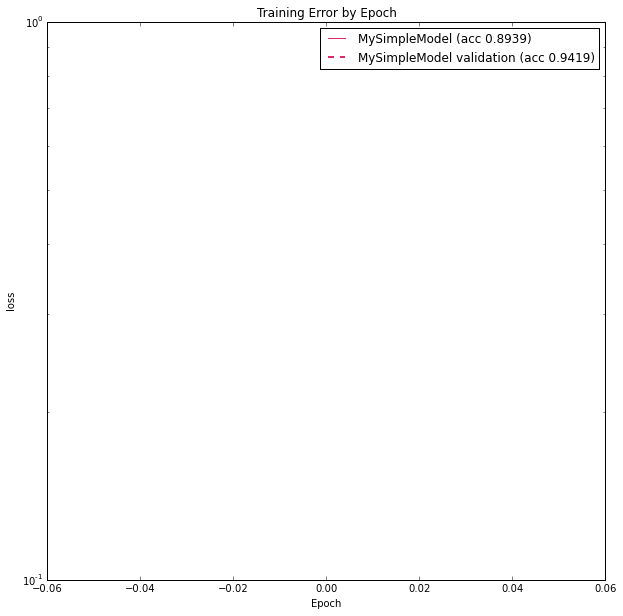

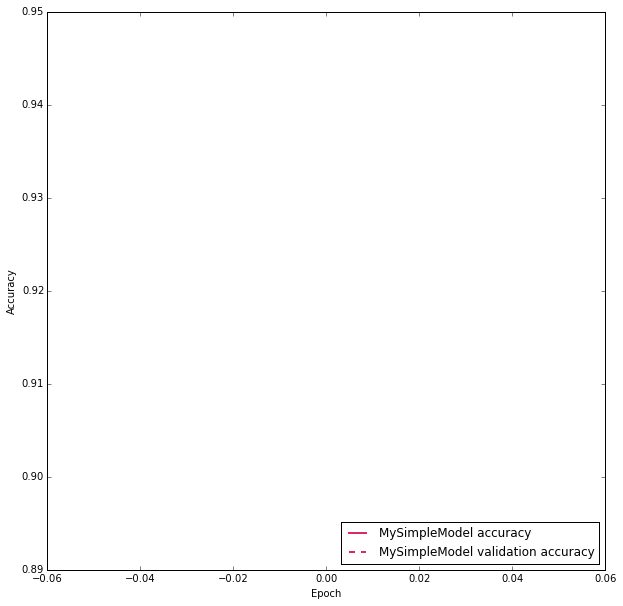

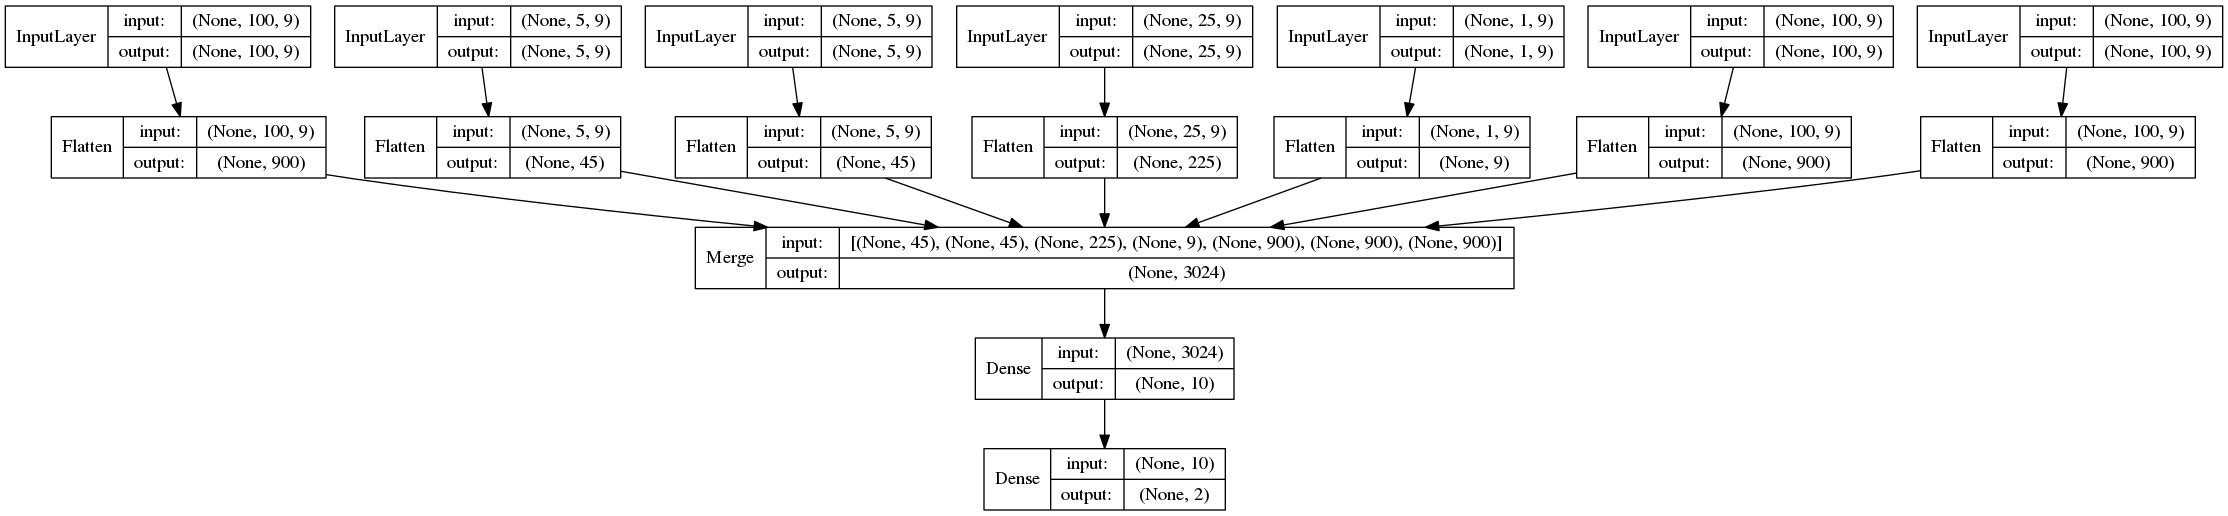

('ElapseTime:', 30.01419100000001)


In [32]:
def genModel(depth, width):
    inputs = [None] * len(object_profiles)
    fist_layer = [None] * len(object_profiles)
    #Build Inputs
    for i,profile in enumerate(object_profiles):
        key = profile.name
        max_size = profile.max_size
        inp = Input(shape=(max_size, vecsize), name=key)
        inputs[i] = inp
        fist_layer[i] = Flatten()(inp)
    #Merge inputs
    merged = merge(fist_layer, mode='concat', name="merge")
    a = merged
    v = [width] * depth
    for j in range(len(v)):
        a = Dense(v[j], activation='relu', name="dense_2_"+str(j))(a)
    second_dense = a 
    
    #Create dense sigmoid layer for classification
    dense_out = Dense(len(label_dir_pairs[:2]), activation='sigmoid', name='main_output')(second_dense)
    dense = Model(input=inputs, output=dense_out, name="dense")
    return dense

#Get the training data
#X_train, Y_train = preprocessFromPandas_label_dir_pairs(label_dir_pairs,
#                                                        sample_start,
#                                                        num_samples,
#                                                        object_profiles,
#                                                        observ_types)

#Generate the model from our function above
model = genModel(1,10)
model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy']
              )

#VERY FEW EPOCHS FOR ILLUSTRATIVE REASONS
epochs = 1
batch_size = 100

earlystopping = EarlyStopping(patience=10, verbose=1)

start_time = time.clock()
history = model.fit_generator(generator=train,
                samples_per_epoch=num_train,
                nb_epoch=epochs,
                validation_data=val,
                nb_val_samples=num_val,
                #YOU SHOULD REALLY USE CALLBACKS AND INCREASE THE # of EPOCHS TO LIKE 100
                callbacks=[earlystopping],
                max_q_size=200,
                nb_worker=1,
                pickle_safe=True)

plot_history([("MySimpleModel", history)])
dot = plot(model, to_file="MySimpleModel.png", show_shapes=True, show_layer_names=False)
display(Image("MySimpleModel.png"))
print("ElapseTime:", time.clock()-start_time)